In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create path
path = os.path.join("hawaii03.sqlite")

In [5]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{path}")

In [6]:
# check if engine is working
engine.execute("SELECT * FROM station")

In [7]:
# Declare a Base
Base = automap_base()

In [8]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Investigate Database

In [12]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [13]:
# get table names
inspector.get_table_names()

['measurement', 'station']

In [14]:
# using inspector to print the column names within the measurement table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
# using inspector to print the column names within the station table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date in the data set is {date[0]}")

The most recent date in the data set is 2017-08-23


In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime(date[0],'%Y-%m-%d')
query_date = recent_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
query = session.query(*sel).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame 
recent_prcp = pd.DataFrame(query, columns=['Date','Precipitation'])

# clean up data set from na entries
recent_prcp = recent_prcp.dropna(how='any')

# Sort the dataframe by date
recent_prcp = recent_prcp.sort_values(['Date'], ascending=True)

# Set the index to the date column
recent_prcp = recent_prcp.set_index('Date')
recent_prcp.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


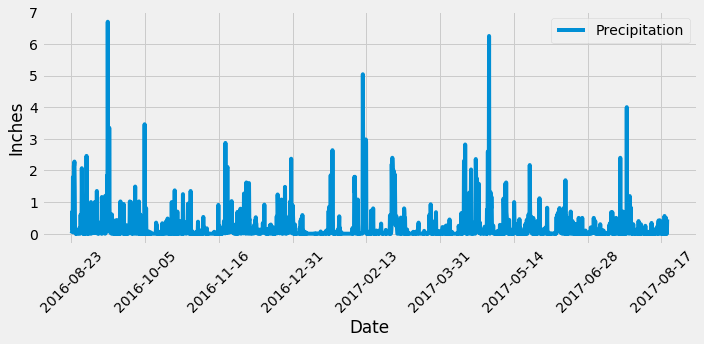

In [91]:
# Use Pandas Plotting with Matplotlib to plot the data
recent_prcp.plot(rot=45)
plt.legend(loc='upper right')
plt.ylabel("Inches")
plt.rcParams["figure.figsize"] = [10,5]
plt.tight_layout()
plt.savefig("Images/precipitation.png")
plt.show()

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
recent_prcp.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [44]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station.id).count()
print(f"The total number of stations is {stations}")

The total number of stations is 9


In [46]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [79]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# active_station = session.query(Measurement.station,Measurement.tobs).filter(Measurement.station == "USC00519281").all()
station_id = 'USC00519281'
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_id).all()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_id).all()
average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_id).all()
print(f"The lowest, highest, and average temp for {station_id} is {lowest_temp[0], highest_temp[0]} and {average_temp[0]}, respectively.")

The lowest, highest, and average temp for USC00519281 is ((54.0,), (85.0,)) and (71.66378066378067,), respectively.


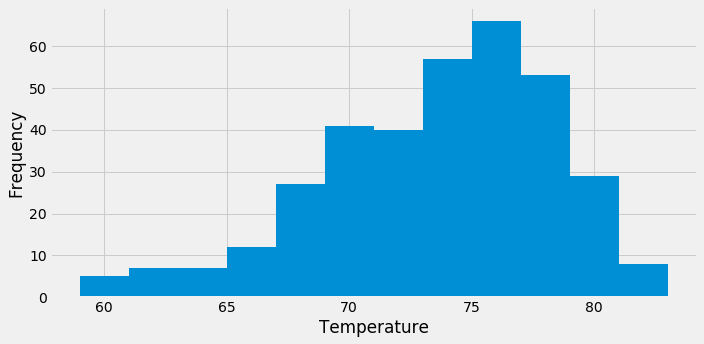

In [89]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.station,Measurement.date,Measurement.tobs]
station_query = session.query(*sel).filter(Measurement.date >= query_date).filter(Measurement.station == station_id).all()

# Save the query results as a Pandas DataFrame 
station_data = pd.DataFrame(station_query, columns=['Station','Date','Temp'])

# clean up data set from na entries
station_data = station_data.dropna(how='any')
# station_count = station_data['Temp'].count()
# station_count

# plot results as a histogram
x = station_data["Temp"]
plt.hist(x,histtype='bar',align='mid', orientation='vertical', bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("Images/temperature.png")
plt.show()


# Close session

In [90]:
# Close Session
session.close()